# Programma che esegue il fit per 3 componenti (SVD):

Per prima cosa è necessario andare a creare la matrice ridotta con sklearn da cui, passandogli il n° di componenti che vuoi, puoi ricavarti i nuovi vettori che saranno:
- U'= $U \cdot S$;
- V'= $V^T$

In [69]:
from sklearn.decomposition import TruncatedSVD
import numpy as np
import pandas as pd
import os

# Carica il DataFrame
df = pd.read_csv('dati_puliti.csv', sep='\t', header=None)
df_original = pd.read_csv('matrice_con_t.dat', sep='\t', header=None)

# Crea un array con le lunghezze d'onda
l_array = df_original.iloc[3:, 0].values
l_array = sorted([float(x.replace(',', '.')) for x in l_array])
l_array = np.array(l_array) # Converti in array numpy x indice


# Funzione per ridurre con SVD
def riduci_svd(matrice, n_componenti):
    svd = TruncatedSVD(n_components=n_componenti)
    U_prime = svd.fit_transform(matrice)  # U'=U*S, fitta il modello cioè calcola comp princ (n_spettri, n_componenti)
    V_prime = svd.components_             # V' (n_componenti, n_colonne (T)) 
    return U_prime, V_prime

# Applica la funzione
U_prime, V_prime = riduci_svd(df, 3)


pd.DataFrame(V_prime).to_csv("V_prime.csv", sep='\t', index=False, header=False)

if not os.path.exists("U_prime.csv"):
    pd.DataFrame(U_prime).to_csv("U_prime.csv", sep='\t', index=False, header=False)

if not os.path.exists("V_prime.csv"):
    pd.DataFrame(V_prime).to_csv("V_prime.csv", sep='\t', index=False, header=False)


# Vediamo come è ordinato l_array
print("Lunghezze d'onda ordinate:")
print(l_array)

Lunghezze d'onda ordinate:
[220.  220.5 221.  221.5 222.  222.5 223.  223.5 224.  224.5 225.  225.5
 226.  226.5 227.  227.5 228.  228.5 229.  229.5 230.  230.5 231.  231.5
 232.  232.5 233.  233.5 234.  234.5 235.  235.5 236.  236.5 237.  237.5
 238.  238.5 239.  239.5 240.  240.5 241.  241.5 242.  242.5 243.  243.5
 244.  244.5 245.  245.5 246.  246.5 247.  247.5 248.  248.5 249.  249.5
 250.  250.5 251.  251.5 252.  252.5 253.  253.5 254.  254.5 255.  255.5
 256.  256.5 257.  257.5 258.  258.5 259.  259.5 260.  260.5 261.  261.5
 262.  262.5 263.  263.5 264.  264.5 265.  265.5 266.  266.5 267.  267.5
 268.  268.5 269.  269.5 270.  270.5 271.  271.5 272.  272.5 273.  273.5
 274.  274.5 275.  275.5 276.  276.5 277.  277.5 278.  278.5 279.  279.5
 280.  280.5 281.  281.5 282.  282.5 283.  283.5 284.  284.5 285.  285.5
 286.  286.5 287.  287.5 288.  288.5 289.  289.5 290.  290.5 291.  291.5
 292.  292.5 293.  293.5 294.  294.5 295.  295.5 296.  296.5 297.  297.5
 298.  298.5 299.  299.5

Ora al fine di fare un fit globale, visto che i parametri in gioco sono molti è necessario fare delle consideraizoni.
L'obiettivo è quello di fare un fit globale delle prime n componenti $V'_i$ con le funzioni $f_i(x)$;
- DoveLa funzione fitted \( f_i(T) \) per ciascuna componente SVD è definita come:

$$
f_i(T) = \sum_{j=1}^{3} C_{ij} \cdot M_j(T)
$$

dove:
- $ i = 1, 2, 3 $ rappresenta le componenti principali $ V'_1, V'_2, V'_3 $;
- $ j = 1, 2, 3 $ rappresenta gli stati conformazionali:
  - $ M_1(T) $: stato Folded
  - $ M_2(T) $: stato Intermedio
  - $ M_3(T) $: stato Unfolded
- $ C_{ij} $ sono i coefficienti di pesatura per ciascuna componente

e, di nuovo, $M_i(x)$ sono le equazioni di Van't Hoff, definite in questo modo:
1) $ M_{1} = \frac {1}{denom} $
2) $ M_{2} = \frac {A}{denom}$
3) $ M_{3} = \frac {A \cdot B}{denom}$

ed: A,B definiti:

1) $ A = exp(- \frac {\Delta H_{1}} {R}) \cdot ((\frac{1}{T_{m1}}- \frac {1}{T})$;
2) $ B = exp(- \frac {\Delta H_{1}} {R}) \cdot ((\frac{1}{T_{m1}}- \frac {1}{T})$

Questo risulta come ho accennato complicato e perciò si ricorre ad un trucco per fissare alcuni parametri; 
Se nel caso in esempio le componenti principali sono 3 (e di conseguenza gli stati del G4 sono 3 F<->I<->U) allora il numero di coefficienti da fissare sarà 12: 
- 2 Tm;
- 2 $ \Delta H$;
- 9 coefficienti $C_{ij}$;

Quindi avendo a disposizione lo spettro F (a T più bassa), e quello U (a T più alta) si esegue un fit locale della forma generale di U' sullo spettro:
$$Spettro_{F,20°}= C_{11} \cdot U_1 + C_{21} \cdot U_2 + C_{31} \cdot U_3$$

$$Spettro_{U,90°}= C_{13} \cdot U_1 + C_{23} \cdot U_2 + C_{33} \cdot U_3$$

In questo modo riusciremo a tenere fissi 6 coefficienti che renderanno il fit globale più semplice.

Tiriamoci fuori i vettori U' e V', intanto:

In [70]:
print("U' :")
print(U_prime[:5])  # prime 5 righe, tutte le colonne (3)

print("\nV' :")
print(V_prime[:, :5])  # tutte le righe (componenti=3), prime 5 colonne

U' :
[[ 2.84475814 -1.46840628  0.71004991]
 [ 2.83056255 -1.46893047  0.70289015]
 [ 2.81852135 -1.49589901  0.70687296]
 [ 2.81691164 -1.50408213  0.69033064]
 [ 2.82737157 -1.50010661  0.69321365]]

V' :
[[ 0.33538661  0.33227776  0.3251999   0.31344372  0.29855929]
 [ 0.26920031  0.25577986  0.22931739  0.20554792  0.1586388 ]
 [ 0.02098376  0.04029992  0.01735415 -0.00789395 -0.02502065]]


Ora andiamo a fittare la forma di U con lo spettro:

Coefficenti della regressione: C11=0.3332250221063488, C21=0.2680242343977617, C31=0.02488528755098099


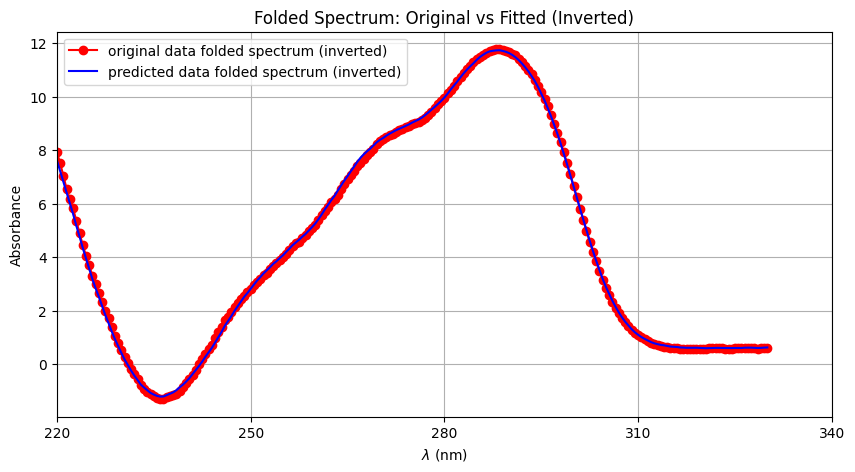

In [71]:
from sklearn.linear_model import LinearRegression
import numpy as np
from matplotlib import pyplot as plt

spttr_F= df.iloc [:,0 ].values  # escludi la prima colonna (lunghezze d'onda)

reg = LinearRegression()

# Fit il modello direttamente senza ordinamento
reg.fit(U_prime, spttr_F)

# Coefficienti
C11, C21, C31 = reg.coef_
print(f"Coefficenti della regressione: C11={C11}, C21={C21}, C31={C31}")

# Predizione dei dati
predicted_F = reg.predict(U_prime)

# Invertiamo solo i dati di `spttr_F` e `predicted`, ma lasciamo `l_array` invariato
spttr_F_reversed = spttr_F[::-1]
predicted_reversed_F = predicted_F[::-1]

# Grafico
plt.figure(figsize=(10, 5))

# Grafico dei dati originali
plt.plot(l_array, spttr_F_reversed, label='original data folded spectrum (inverted)', marker='o', color='red')

# Grafico dei dati predetti
plt.plot(l_array, predicted_reversed_F, label='predicted data folded spectrum (inverted)', linestyle='-', color='blue')

# Titolo e etichette
plt.title('Folded Spectrum: Original vs Fitted (Inverted)')
plt.xlabel(r'$\lambda$ (nm)')
plt.xlim(min(l_array), max(l_array))
step_size = 30
ticks = np.arange(min(l_array), max(l_array) + step_size, step_size)
plt.xticks(ticks)

plt.ylabel('Absorbance')
plt.grid(True)
plt.legend()
plt.show()


Coefficenti:
C13: 0.0797639032456743, C23: -0.05410112018044699, C33: 0.3093950932907559


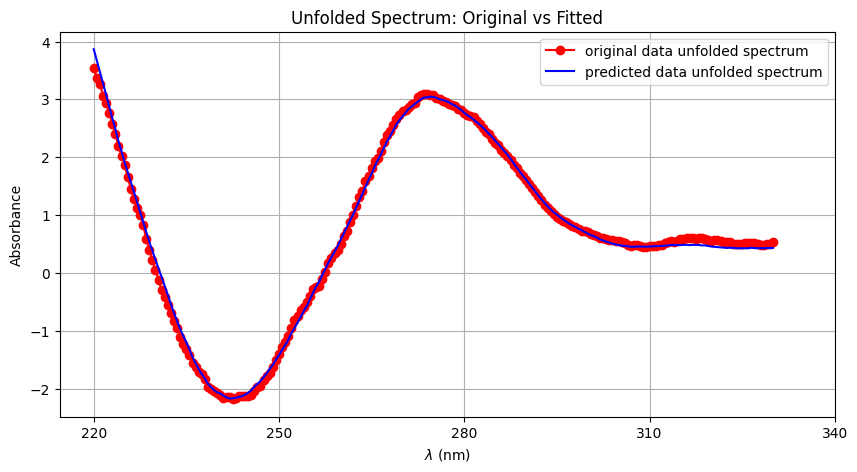

In [72]:
spttr_U = df.iloc[:, -1].values # ultima colonna (spettro unfolded)
reg.fit(U_prime, spttr_U)  # addestra il modello
C13,C23,C33 = reg.coef_  # coefficenti
predicted_U = reg.predict(U_prime)  # predizione
print("\nCoefficenti:")
print(f"C13: {C13}, C23: {C23}, C33: {C33}")

spttr_U_reversed = spttr_U[::-1]
predicted_reversed_U = predicted_U[::-1]

plt.figure(figsize=(10, 5))
plt.plot(l_array, spttr_U_reversed, label= 'original data unfolded spectrum', marker='o', color='red')
plt.plot(l_array, predicted_reversed_U, label= 'predicted data unfolded spectrum', linestyle='-', color='blue')
plt.title('Unfolded Spectrum: Original vs Fitted')
plt.xlabel(r'$\lambda$ (nm)')
step_size = 30
ticks = np.arange(min(l_array), max(l_array) + step_size, step_size)
plt.xticks(ticks)
plt.ylabel('Absorbance')
plt.grid(True)
plt.legend()
plt.show()

Ora abbiamo i primi 6 coefficienti.
Ci resta solamente da fare il fit globale grazie alle funzioni di Van't Hoff.

In [73]:
# Creazione array per le temperature
t_csv = pd.read_csv('matrice_con_t.dat', sep='\t', header=None)
t_array = t_csv.iloc[0, 1:].astype(float).values # prima riga, da 2 in poi
T_kelvin = t_array + 273.15

R = 1.987  # cal/(mol·K)

print("\nTemperatura (K):")
print(T_kelvin[:5])  # prime 5 righe


Temperatura (K):
[293.15 295.15 297.15 299.15 301.15]


Qui è stato fatto un global-fit per il modello F<->I<->U.
In cui è ovviamante presente uno stadio intermedio tra la conformazione Folded and Unfolded. 

**MODELLO SEQUENZIALE**

In [74]:
def calc_M_2p(T, Tm1, Tm2, dH1, dH2):
    # calcolo M_i(T) per i tre stati
    A = np.exp(-dH1 / R * (1/Tm1 - 1/T))
    B = np.exp(-dH2 / R * (1/Tm2 - 1/T))
    denom = 1 + (A*B) + A
    M1 = 1 / denom
    M2 = A / denom
    M3 = (A*B) / denom
    return np.stack([M1, M2, M3], axis=0)  # shape (3, len(T))


from scipy.optimize import least_squares

def residui_p(params, T, V_prime, C_fix): # una funzione che restituisce SOLO la differenza tra i dati e il modello ma serve per far andare LeastSquares
    
    # costruisce C
    # calcola M_i(T) per i tre stati -> M
    # calcola f_i(T) = sum_j C_ij * M_j(T) -> f_pred
    # calcola residui = V_prime - f_pred -> residui

    # unpack parametri liberi
    Tm1, Tm2, dH1, dH2 = params[:4]
    C12, C22, C32 = params[4:]

    # ricostruisci tutti i Cij
    C = np.array([
        [C_fix['C11'], C12,  C_fix['C13']],
        [C_fix['C21'],          C22,  C_fix['C23']],
        [C_fix['C31'], C32,  C_fix['C33']]
    ])  # shape (3, 3)

    # calcolo le M_i(T)
    M = calc_M_2p(T, Tm1, Tm2, dH1, dH2)  # shape (3, len(T))

    # calcolo f_i(T) = sum_j C_ij * M_j(T)
    f_pred = C @ M  # shape (3, len(T))

    # flatten dei residui
    return (V_prime - f_pred).flatten()


# dizionario dei C fissi (già calcolati)
C_fix = {
    'C11': C11,
    'C21': C21,
    'C31': C31,
    'C13': C13,
    'C23': C23,
    'C33': C33
}

# valori iniziali plausibili (Tm in K, ΔH in cal/mol, C arbitrari)
p0 = [330, 354, -21000, -35000, 0.3, 0.3, 0.3] #valori per i parametri termodinamici presi circa da letteratura

residui_init = residui_p(p0, T_kelvin, V_prime, C_fix)
print("Valori iniziali dei residui:", residui_init[:10])
print("Contengono NaN?", np.any(np.isnan(residui_init)))
print("Contengono inf?", np.any(np.isinf(residui_init)))


# prova params fino a che sono minimi (1000) residui_p
# poi salva i params ottimizzati in res.x

res_p = least_squares( # chiama i residui con diversi params (prove)e trova i valori ottimali, al termine trovi tutto su res.x
    residui_p,
    p0,
    args=(T_kelvin, V_prime, C_fix),
    method='trf' # 'trf' è il metodo di Levenberg-Marquardt
)

# Stampa formattata dei parametri ottimizzati
param_labels = ['Tm1', 'Tm2', 'ΔH1', 'ΔH2', 'C12', 'C22', 'C32']
param_units = ['K', 'K', 'cal/mol', 'cal/mol', '', '', '']

print("\nParametri ottimizzati:")
for label, unit, value in zip(param_labels, param_units, res_p.x):
    print(f"{label:>4} = {value:10.2f} {unit}")


Valori iniziali dei residui: [ 0.00274435 -0.00020673 -0.00708829 -0.01860158 -0.03318733 -0.05258278
 -0.07460165 -0.10260395 -0.13131014 -0.15683692]
Contengono NaN? False
Contengono inf? False

Parametri ottimizzati:
 Tm1 =     307.89 K
 Tm2 =     334.19 K
 ΔH1 =  -44657.51 cal/mol
 ΔH2 =  -16754.17 cal/mol
 C12 =       0.09 
 C22 =      -0.31 
 C32 =      -0.33 


Il grafico connesso al fit con il chi quadro ridotto:

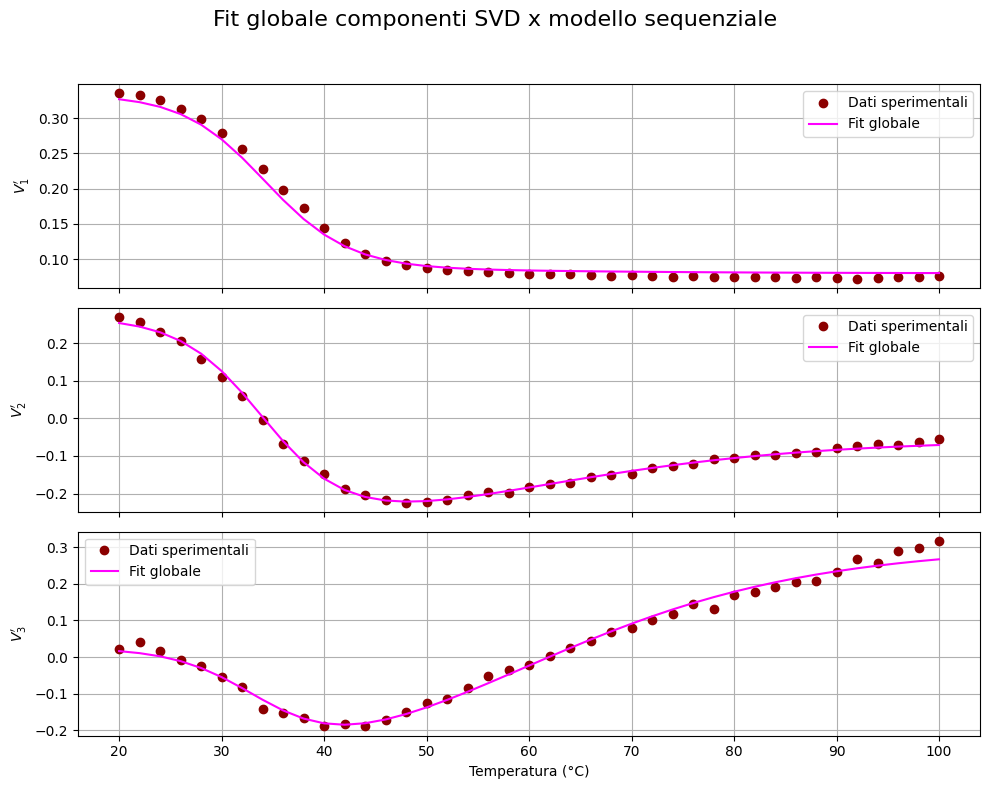


Chi quadro ridotto: 0.00013


In [75]:
Tm1, Tm2, dH1, dH2 = res_p.x[:4]
C12, C22, C32 = res_p.x[4:]

# ricostruzione della matrice C
C_opt = np.array([
    [C_fix['C11'], C12,  C_fix['C13']],
    [C_fix['C21'],          C22,  C_fix['C23']],
    [C_fix['C31'], C32,  C_fix['C33']]
])

# calcolo delle M con le T usate nel fit
M_opt_p_p = calc_M_2p(T_kelvin, Tm1, Tm2, dH1, dH2) # shape (3, len(T)) M ottimizzata
f_pred_p = C_opt @ M_opt_p_p  # shape (3, len(T))

# Calcolo chi quadro ridotto
residuals_p = V_prime - f_pred_p # residui
chi2_p = np.sum(residuals_p**2) # somma dei residui al quadrato (err tot)
dof = V_prime.size - len(res_p.x)  # gradi di libertà = numero di dati - numero di parametri
chi2_red_p = chi2_p / dof # chi quadro ridotto

# Plot
fig, axs = plt.subplots(3, 1, figsize=(10, 8), sharex=True)
labels = [r"$V_1'$", r"$V_2'$", r"$V_3'$"]

for i in range(3):
    axs[i].plot(t_array, V_prime[i], 'o', label='Dati sperimentali', color='darkred')
    axs[i].plot(t_array, f_pred_p[i], '-', label='Fit globale', color='magenta')
    axs[i].set_ylabel(labels[i])
    axs[i].grid(True)
    axs[i].legend()

axs[2].set_xlabel("Temperatura (°C)")
plt.suptitle(r"Fit globale componenti SVD x modello sequenziale", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
print(f"\nChi quadro ridotto: {chi2_red_p:.5f}")

**N.B.:** $\chi^2$ ridotto così piccolo normalmente indicherebbe un overfitting per assenza di rumore ma nel nostro caso stiamo filtrando il rumore con la tecnica SVD e quindi vogliamo che il  $\chi^2$ ridotto sia così piccolo.

Di seguito, invece, si considera di fittare per il modello F1<->U<->F2.

**MODELLO PARALLELO**

In [76]:
def calc_M_2s(T, Tm1, Tm2, dH1, dH2):
    # calcolo M_i(T) per i tre stati
    A = np.exp(-dH1 / R * (1/Tm1 - 1/T))
    B = np.exp(-dH2 / R * (1/Tm2 - 1/T))
    denom = 1 + A + B
    M1 = 1 / denom
    M2 = A / denom
    M3 = B / denom
    return np.stack([M1, M2, M3], axis=0)  # shape (3, len(T))


def residui_s(params, T, V_prime, C_fix):
    # unpack parametri liberi
    Tm1, Tm2, dH1, dH2 = params[:4]
    C12, C22, C32 = params[4:]

    # ricostruisci tutti i Cij
    C = np.array([
        [C_fix['C11'], C12,  C_fix['C13']],
        [C_fix['C21'],          C22,  C_fix['C23']],
        [C_fix['C31'], C32,  C_fix['C33']]
    ])  # shape (3, 3)

    # calcolo le M_i(T)
    M = calc_M_2s(T, Tm1, Tm2, dH1, dH2)  # shape (3, len(T))

    # calcolo f_i(T) = sum_j C_ij * M_j(T)
    f_pred = C @ M  # shape (3, len(T))

    # flatten dei residui
    return (V_prime - f_pred).flatten()


residui_init = residui_s(p0, T_kelvin, V_prime, C_fix)
print("Valori iniziali dei residui:", residui_init[:10])
print("Contengono NaN?", np.any(np.isnan(residui_init)))
print("Contengono inf?", np.any(np.isinf(residui_init)))


res_s = least_squares(
    residui_s,
    p0,
    args=(T_kelvin, V_prime, C_fix),
    method='trf'
)

# Stampa formattata dei parametri ottimizzati
param_labels = ['Tm1', 'Tm2', 'ΔH1', 'ΔH2', 'C12', 'C22', 'C32']
param_units = ['K', 'K', 'cal/mol', 'cal/mol', '', '', '']

print("\nParametri ottimizzati:")
for label, unit, value in zip(param_labels, param_units, res_s.x):
    print(f"{label:>4} = {value:10.2f} {unit}")

Valori iniziali dei residui: [ 0.00275233 -0.00019487 -0.0070708  -0.01857602 -0.03315031 -0.05252971
 -0.07452643 -0.10249869 -0.13116493 -0.15663987]
Contengono NaN? False
Contengono inf? False

Parametri ottimizzati:
 Tm1 =     305.67 K
 Tm2 =  -22368.96 K
 ΔH1 =  -59957.14 cal/mol
 ΔH2 =  -56671.91 cal/mol
 C12 =       0.09 
 C22 =      -0.15 
 C32 =       0.05 


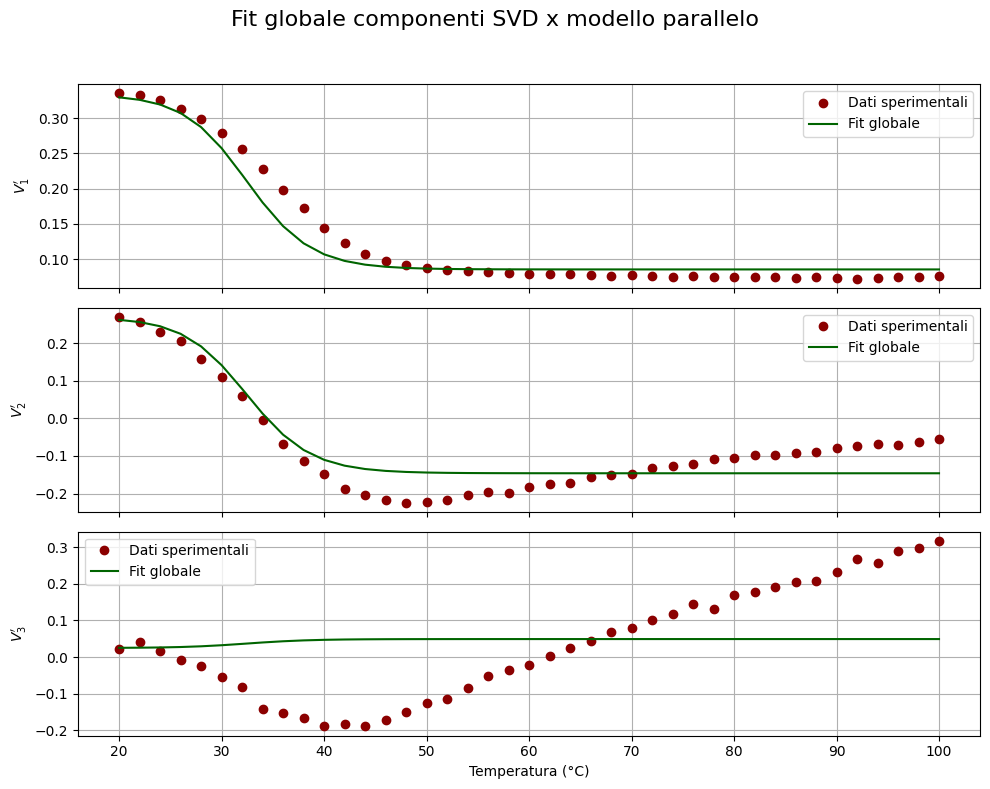


Chi quadro ridotto: 0.00906


In [77]:
Tm1, Tm2, dH1, dH2 = res_s.x[:4]
C12, C22, C32 = res_s.x[4:]

# ricostruzione della matrice C
C_opt = np.array([
    [C_fix['C11'], C12,  C_fix['C13']],
    [C_fix['C21'],          C22,  C_fix['C23']],
    [C_fix['C31'], C32,  C_fix['C33']]
])

# calcolo delle M con le T usate nel fit
M_opt_s = calc_M_2s(T_kelvin, Tm1, Tm2, dH1, dH2)
f_pred_s = C_opt @ M_opt_s  # shape (3, len(T))

# Calcolo chi quadro ridotto
residuals_s = V_prime - f_pred_s
chi2_s = np.sum(residuals_s**2) # somma dei residui al quadrato
dof = V_prime.size - len(res_s.x)  # gradi di libertà
chi2_red_s = chi2_s / dof # chi quadro ridotto

# Plot
fig, axs = plt.subplots(3, 1, figsize=(10, 8), sharex=True)
labels = [r"$V_1'$", r"$V_2'$", r"$V_3'$"]

for i in range(3):
    axs[i].plot(t_array, V_prime[i], 'o', label='Dati sperimentali', color='darkred')
    axs[i].plot(t_array, f_pred_s[i], '-', label='Fit globale', color='darkgreen')
    axs[i].set_ylabel(labels[i])
    axs[i].grid(True)
    axs[i].legend()

axs[2].set_xlabel("Temperatura (°C)")
plt.suptitle(r"Fit globale componenti SVD x modello parallelo", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
print(f"\nChi quadro ridotto: {chi2_red_s:.5f}")

Per ultima cosa confrontiamo visivamente i due fit per capire (anche se risulta già chiaro) quale modello si adatta in maniera migliore al caso in esame

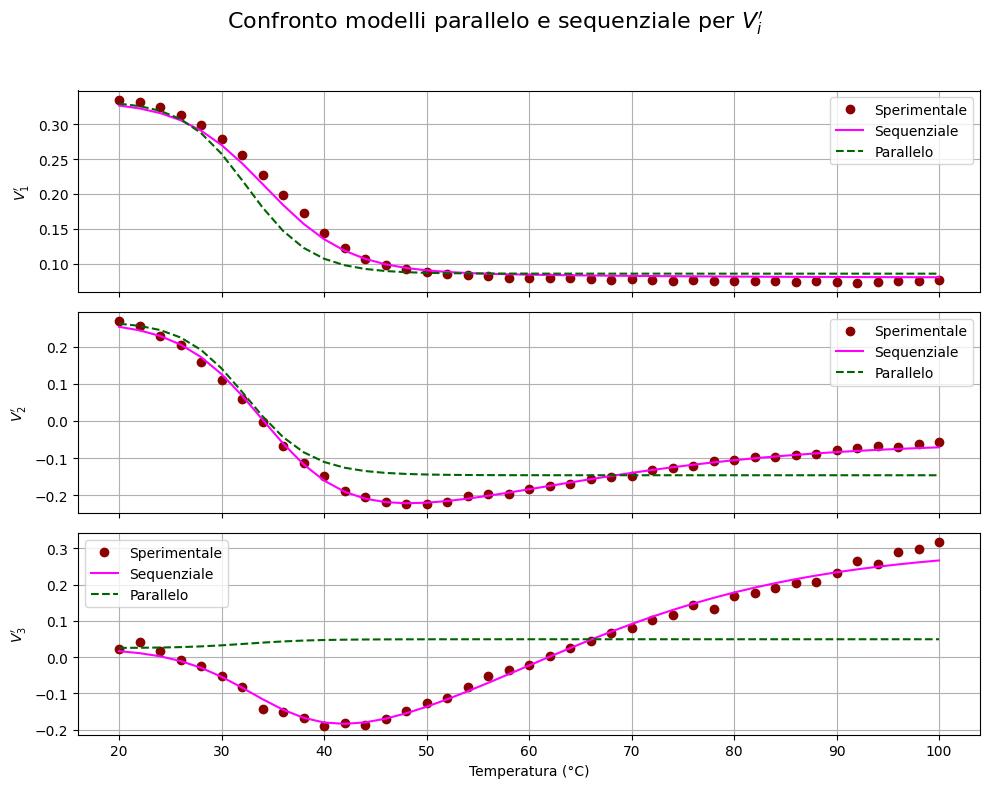

In [78]:
# Grafico comparativo dei due modelli
fig, axs = plt.subplots(3, 1, figsize=(10, 8), sharex=True)
labels = [r"$V_1'$", r"$V_2'$", r"$V_3'$"]

for i in range(3):
    axs[i].plot(t_array, V_prime[i], 'o', label='Sperimentale', color='darkred')
    axs[i].plot(t_array, f_pred_p[i], '-', label='Sequenziale', color='magenta')
    axs[i].plot(t_array, f_pred_s[i], '--', label='Parallelo', color='darkgreen')
    axs[i].set_ylabel(labels[i])
    axs[i].grid(True)
    axs[i].legend(loc='best')

axs[2].set_xlabel("Temperatura (°C)")
plt.suptitle(
    rf"Confronto modelli parallelo e sequenziale per $V_i'$", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


Ora io ho fittato i due modelli e capito quale dei due è il caso che sto studiando: ora vado a rifittare per il modello scelto i $C_{i,j} $ che avevo in precedenza tenuti fissi.

Richiamo la funzione che avevo ottimizzato f_pred_p e la fitto lasciando i parametri precedentemente fissati come liberi e quelli liberi fissati.

Questo secondo fit è fortemente dipendente dalle forme degli spettri; in questo caso ho scelto di tenere fissi i parametri termodinamici che sembrano in linea con i valori in letterautra e i coefficienti dello stato unfolded. 
Verrà quindi fatto il secondo fit per i coefficienti dello stato folded and intermediate.

In [79]:
tot_params = [C11, C12, C13, C21, C22, C23] 
Tm1, Tm2, dH1, dH2 = res_p.x[:4]
C31, C32, C33 = C_fix['C31'], res_p.x[6], C_fix['C33']  # solo se fit completo
 # Cij fissi


def residui_totali(tot_params, T, V_prime, modello_fn, Tm1, Tm2, dH1, dH2, C31, C32, C33):  
    
    C11, C12, C13, C21,C22, C23 = tot_params
    C = np.array([
        [C11, C12, C13],
        [C21, C22, C23],
        [C31, C32, C33]
    ])  # ricostruisce la matrice 3x3

    M = modello_fn(T, Tm1, Tm2, dH1, dH2)  # M.shape = (3, len(T))
    f_pred = C @ M
    return (V_prime - f_pred).flatten()

tot_p0 = [
    C_fix['C11'], res_p.x[4], C_fix['C13'],
    C_fix['C21'], res_p.x[5], res_p.x[6]
]

tot_res = least_squares(
    residui_totali,
    tot_p0,
    args=(T_kelvin, V_prime, calc_M_2p, Tm1, Tm2, dH1, dH2, C31, C32, C33),
    method='trf'
)

tot_c_labels = ['C11', 'C12', 'C13', 'C21', 'C22', 'C23']
print("\nParametri C ottimizzati (con Tm e ΔH fissi):")
for label, value in zip(tot_c_labels, tot_res.x):
    print(f"{label} = {value:.4f}")




Parametri C ottimizzati (con Tm e ΔH fissi):
C11 = 0.3450
C12 = 0.0908
C13 = 0.0706
C21 = 0.2682
C22 = -0.3089
C23 = -0.0498


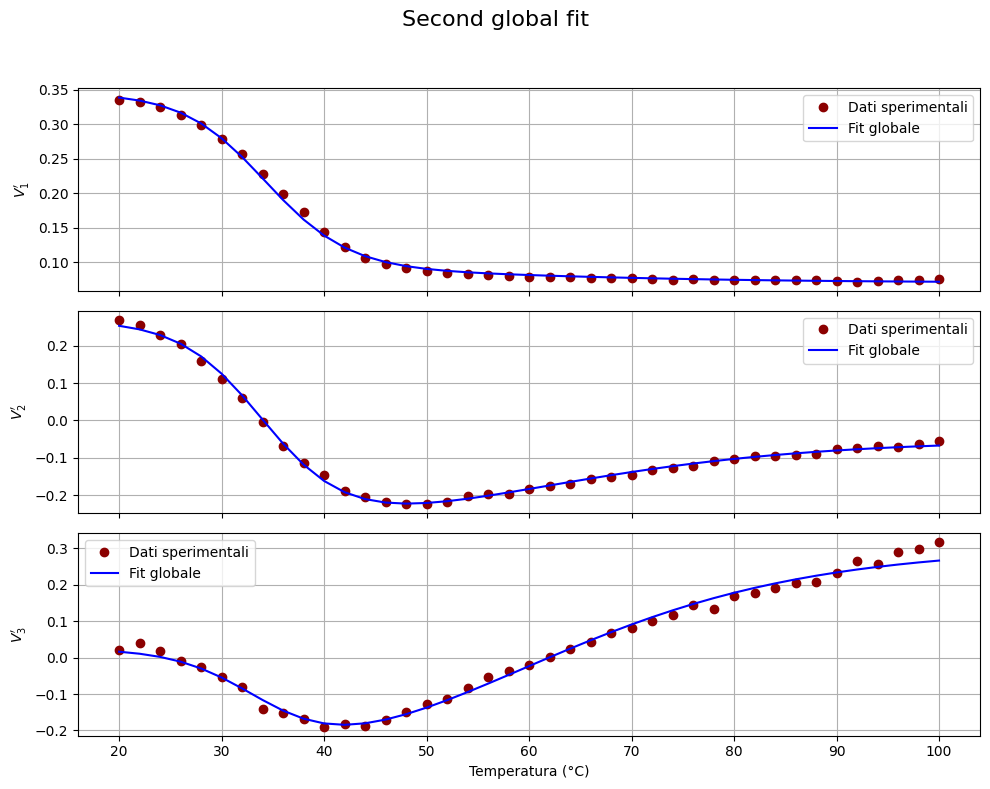


Chi quadro ridotto: 0.00011


In [80]:
# Ricostruzione della matrice C ottimizzata
C11, C12, C13, C21, C22, C23 = tot_res.x
C_opt = np.array([
    [C11, C12, C13],
    [C21, C22, C23],
    [C31, C32, C33]
])

# Calcolo delle M con i T fissi FINALI
M_opt_secfit = calc_M_2p(T_kelvin, Tm1, Tm2, dH1, dH2)
f_pred_secfit = C_opt @ M_opt_secfit  # shape (3, len(T))

# Calcolo chi² ridotto
residuals = V_prime - f_pred_secfit
chi2 = np.sum(residuals**2)
dof = V_prime.size - len(tot_res.x)
chi2_red = chi2 / dof


# Plot
fig, axs = plt.subplots(3, 1, figsize=(10, 8), sharex=True)
labels = [r"$V_1'$", r"$V_2'$", r"$V_3'$"]

for i in range(3):
    axs[i].plot(T_kelvin - 273.15, V_prime[i], 'o', label='Dati sperimentali', color='darkred')
    axs[i].plot(T_kelvin - 273.15, f_pred_secfit[i], '-', label='Fit globale', color='blue')
    axs[i].set_ylabel(labels[i])
    axs[i].grid(True)
    axs[i].legend()

axs[2].set_xlabel("Temperatura (°C)")
plt.suptitle("Second global fit", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

print(f"\nChi quadro ridotto: {chi2_red:.5f}")


Per ultima cosa, salvo i parametri ottimizzati (tutti e 13), in un file csv che useremo nel prossimo programma al fine di ricostruire gli spettri.

In [81]:
# salva i parametri ottimizzati in un file CSV
parametri_ottimizzati = pd.DataFrame({
    'Parametri': ['Tm1', 'Tm2', 'dH1', 'dH2', 'C11', 'C12', 'C13', 'C21', 'C22', 'C23', 'C31', 'C32', 'C33'],   
    'Valori': [Tm1, Tm2, dH1, dH2, C11, C12, C13, C21, C22, C23, C31, C32, C33]
})

parametri_ottimizzati.head()

,Parametri,Valori
0,Tm1,307.893541
1,Tm2,334.194405
2,dH1,-44657.509726
3,dH2,-16754.172207
4,C11,0.344965


In [82]:
if not os.path.exists("parametri_ottimizzati.csv"):
    parametri_ottimizzati.to_csv("parametri_ottimizzati.csv", sep='\t', index=False, header=False)

if not os.path.exists("M_matrix.csv"):
    pd.DataFrame(M_opt_secfit).to_csv("M_matrix.csv", sep='\t', index=False, header=False)